<a href="https://colab.research.google.com/github/hasanahmedfaisal/imageClassifier/blob/master/ImageClassifierAssignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install -q torch==1.3.1 torchvision

In [1]:
%cd /content/
!if ! test -d aipnd-project/; then git clone https://github.com/udacity/aipnd-project.git ; fi  
%cd aipnd-project/
!mkdir -p flowers/
%cd flowers/
!wget -nc https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz
!if ! test -d test/; then tar -xzf flower_data.tar.gz; fi  
!ls -l
%cd /content/aipnd-project/
!ls -l

/content
Cloning into 'aipnd-project'...
remote: Enumerating objects: 35, done.
remote: Total 35 (delta 0), reused 0 (delta 0), pack-reused 35
Unpacking objects: 100% (35/35), done.
/content/aipnd-project
/content/aipnd-project/flowers
--2019-12-08 17:49:53--  https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.104.189
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.104.189|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 344873452 (329M) [application/x-gzip]
Saving to: ‘flower_data.tar.gz’

flower_data.tar.gz  100%[===================>] 328.90M  45.4MB/s    in 7.7s    

2019-12-08 17:50:01 (42.8 MB/s) - ‘flower_data.tar.gz’ saved [344873452/344873452]

total 336808
-rw-r--r--   1 root root 344873452 Jan 26  2018 flower_data.tar.gz
drwxrwxr-x 104 1000 1000      4096 Jan 15  2018 test
drwxrwxr-x 104 1000 1000      4096 Jan 15  2018 train
drwxrwxr-x 104 1000 1000      4096 Jan

In [2]:
%cd /content/aipnd-project/
!ls -l
%cd /content/
!ls -l

/content/aipnd-project
total 40
drwxr-xr-x 2 root root  4096 Dec  8 17:49  assets
-rw-r--r-- 1 root root  2218 Dec  8 17:49  cat_to_name.json
drwxr-xr-x 5 root root  4096 Dec  8 17:50  flowers
-rw-r--r-- 1 root root 17748 Dec  8 17:49 'Image Classifier Project.ipynb'
-rw-r--r-- 1 root root  1064 Dec  8 17:49  LICENSE
-rw-r--r-- 1 root root     0 Dec  8 17:49  predict.py
-rw-r--r-- 1 root root   250 Dec  8 17:49  README.md
-rw-r--r-- 1 root root     0 Dec  8 17:49  train.py
/content
total 8
drwxr-xr-x 5 root root 4096 Dec  8 17:49 aipnd-project
drwxr-xr-x 1 root root 4096 Nov 27 22:38 sample_data


In [0]:
# import depencencies

import torch 
from torch import nn, optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models

import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

from PIL import Image

import json

In [0]:
data_dir = '/content/aipnd-project/flowers'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

In [0]:
# transform operations training, validation, and testing sets
train_transforms = transforms.Compose([transforms.RandomResizedCrop(224),
                                       transforms.RandomRotation(30),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])]) 

test_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])])

# datasets for training, testing, validation
train_datasets = datasets.ImageFolder(train_dir,train_transforms)
valid_datasets = datasets.ImageFolder(valid_dir,test_transforms)
test_datasets = datasets.ImageFolder(test_dir,test_transforms)



# dataloaders
train_dataloaders = torch.utils.data.DataLoader(train_datasets, batch_size=64, shuffle= True )
valid_dataloaders = torch.utils.data.DataLoader(valid_datasets, batch_size=64, shuffle= True )
test_dataloaders = torch.utils.data.DataLoader(test_datasets, batch_size=32 )

In [0]:
# mapping integer encoded category to names
with open('/content/aipnd-project/cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

In [0]:
rsnet_model = models.resnet50(pretrained = True)
rsnet_model

In [0]:
#freezing parameters of model
for param in rsnet_model.parameters():
    param.requires_grad = False

In [9]:
#Defining Classifier
class Network(nn.Module):
    def __init__(self,input_size, hiddenlayers, output_size, drop_p = 0.5):
        
        super().__init__()
        
        self.hidden_layers = nn.ModuleList([nn.Linear(input_size, hiddenlayers[0])])
        
        layersizes = zip(hiddenlayers[:-1],hiddenlayers[1:])
        
        self.hidden_layers.extend([nn.Linear(h1,h2) for h1,h2 in layersizes])
        
        self.output = nn.Linear(hiddenlayers[-1],output_size)
                
        self.dropout = nn.Dropout(p = drop_p)
        
    def forward(self , x):
        
        for lin in self.hidden_layers:
            x = F.relu(lin(x))
            x = self.dropout(x)
            
        x = self.output(x)
        
        return F.log_softmax(x, dim= 1)

#set calssifer for model
fcclassifier = Network(2048,[512],102)

fcclassifier

Network(
  (hidden_layers): ModuleList(
    (0): Linear(in_features=2048, out_features=512, bias=True)
  )
  (output): Linear(in_features=512, out_features=102, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [0]:

rsnet_model.fc = fcclassifier
rsnet_model

In [0]:
#Set device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu" )

In [0]:
#Validation 
def Validation(model,criterion,valid_dataloaders):
    testloss = 0
    accuracy = 0
    totaldatasetlen = 0
    model.to(device)

    for images , labels in valid_dataloaders:
        images,labels = images.to(device),labels.to(device)
        output = model.forward(images)
        testloss += criterion(output, labels).item()
        
        ps = torch.exp(output)
        
        equity = (labels == ps.max(dim = 1)[1])
        totaldatasetlen +=labels.size(0)
        accuracy += equity.type(torch.FloatTensor).mean()
    
    
    return testloss,accuracy,totaldatasetlen

In [0]:
#train the network
def trainthemodel(model,optimizer,criterion,train_dataloaders,valid_dataloaders,epochs = 10,print_every = 40,):
    

    running_loss = 0 
    steps = 0
    
    model.to(device)

    print("The training about to start and print every {} steps...".format(printevery))
    print("The divice its running on is : {}. ..".format(device))


    for e in range(epochs):
        model.train()
        
        for images,labels in train_dataloaders:
            steps += 1
            images,labels = images.to(device),labels.to(device)
            optimizer.zero_grad()
            output = model.forward(images)
            Loss = criterion(output,labels)
            
            Loss.backward()
            optimizer.step()
            
            running_loss += Loss.item()
            
            
            if steps%printevery == 0:
                model.eval()
                with torch.no_grad():
                    test_loss,accuracy,totaldatalen = Validation(model,criterion,valid_dataloaders)
                
                print("The no of steps is {}...".format(steps),
                      "The epoch is {}/{}....".format(e+1 ,epochs),
                      "The Loss of model is {:.4f}...".format(running_loss/printevery),
                      "Test Loss: {:.3f}.. ".format(test_loss/len(valid_dataloaders)),
                      "Test Accuracy: {:.3f}%".format(accuracy/len(valid_dataloaders) * 100)
                 )
                
                running_loss = 0
                model.train()    
            
    print("Training Complete")

In [0]:
# Do validation on testset

def Acuuracyontestset(model,criterion,test_dataloaders):
    testloss = 0
    accuracy = 0
    totaldatasetlen = 0
    
    model.to(device)
    
    model.eval()
    for images , labels in test_dataloaders:
        images,labels = images.to(device),labels.to(device)
        output = model.forward(images)        
        ps = torch.exp(output)
        
        equity = (labels == ps.max(dim = 1)[1])
        totaldatasetlen +=labels.size(0)
        accuracy += equity.type(torch.FloatTensor).sum().item()
    
    
    return accuracy,totaldatasetlen

In [0]:
def Acurracy(model):
    print("Calculating Acuracy:")
    with torch.no_grad():
        accuracy,total = Acuuracyontestset(model,criterion,test_dataloaders)
    
    print('Accuracy of the network on the {} test images: {}%...'.format(total,(100 * accuracy / total)))
    
    return (100 * accuracy / total)

In [0]:
# Save the checkpoint 
def savecheckpoint(filename):
    modelcheckpoint = { 'input_size':2048,
                  'output_size':102,
                   'epochs': epochs,
                    'learningrate': learningrate,
                   'model' : models.resnet50(pretrained= True),
                   'classifier' : rsnet_model.fc,
                   'state_Dict': rsnet_model.state_dict(),
                   'class_to_idx': train_datasets.class_to_idx
                   }

    torch.save(modelcheckpoint, filename)
    print("The model is saved in {} file..".format(filename))

In [0]:
#  function that loads a checkpoint and rebuilds the model
def loadCheckpoint(filepath):
    
    if device == 'cuda:0':
        checkpoint = torch.load(filepath)
    else:
        checkpoint = torch.load(filepath, map_location=lambda storage, loc: storage)
    
    model = checkpoint['model']
    for param in model.parameters():
        param.requires_grad = False
    
    model.fc = checkpoint['classifier']
    model.load_state_dict(checkpoint['state_Dict'])
    epochs = checkpoint['epochs']
    model.class_to_idx = checkpoint['class_to_idx']
    
    print("The model is loaded from {} file..".format(filepath))
    return model

In [0]:
printevery = 40
epochs = 10

learningrate = 0.0005

criterion = nn.NLLLoss()
optimizer = optim.Adam(rsnet_model.fc.parameters(), lr = learningrate)

In [19]:
    
trainthemodel(rsnet_model,optimizer,criterion,train_dataloaders,valid_dataloaders,epochs,printevery)
old_acuraccy = Acurracy(rsnet_model)

The training about to start and print every 40 steps...
The divice its running on is : cuda:0. ..
The no of steps is 40... The epoch is 1/10.... The Loss of model is 4.4312... Test Loss: 4.075..  Test Accuracy: 13.611%
The no of steps is 80... The epoch is 1/10.... The Loss of model is 4.0116... Test Loss: 3.518..  Test Accuracy: 25.385%
The no of steps is 120... The epoch is 2/10.... The Loss of model is 3.5604... Test Loss: 2.943..  Test Accuracy: 34.947%
The no of steps is 160... The epoch is 2/10.... The Loss of model is 3.1141... Test Loss: 2.465..  Test Accuracy: 44.062%
The no of steps is 200... The epoch is 2/10.... The Loss of model is 2.7606... Test Loss: 2.081..  Test Accuracy: 52.558%
The no of steps is 240... The epoch is 3/10.... The Loss of model is 2.4761... Test Loss: 1.848..  Test Accuracy: 58.274%
The no of steps is 280... The epoch is 3/10.... The Loss of model is 2.2240... Test Loss: 1.558..  Test Accuracy: 67.798%
The no of steps is 320... The epoch is 4/10.... Th

In [20]:
  
filename = 'checkpointresnet.pth'
savecheckpoint(filename)
rsnet_model = loadCheckpoint(filename) 

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type ResNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Conv2d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type BatchNorm2d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type ReLU. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist

The model is saved in checkpointresnet.pth file..
The model is loaded from checkpointresnet.pth file..


In [0]:
def predict(image_path, model, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    
    # TODO: Implement the code to predict the class from an image file
    
    image = process_image(image_path)
    
    #print(image.shape)

    image.unsqueeze_(0)
    
    #print(image.shape)
    
    image = image

    image = image.to(device)
    
    model.type(torch.DoubleTensor)
    
    model.to(device)
    
    model.eval()
    
    with torch.no_grad():
        
        output = model.forward(image)
        
        prob = torch.exp(output)
        
        probs , indices = torch.topk(prob , topk) 
        
                
        indice = indices.cpu()
        
        indice = indice.numpy()[0]
        
        # Convert indices to classes
        idx_to_class = {val: key for key, val in model.class_to_idx.items()}  
        
        #print(idx_to_class)
        
        classes = [idx_to_class[index] for index in indice]
        
    
    return  probs , classes
        

In [0]:
def SanityCheck(path):
    
    image = Image.open(path)
    
    lis = path.split("/")
    
    OriginalClass = cat_to_name[lis[-2]]
    
    probs, classes = predict(path, rsnet_model)
    
    probs = probs.cpu()
    probs = probs.numpy()
    
    TopKClasses = [cat_to_name[clas] for clas in classes]
    
    
    plt.figure(figsize = [5, 10]) # larger figure size for subplots
    
    #Original Image
    ax = plt.subplot(2,1,1)
    
    image = np.array(image)
    
    ax.imshow(image)
    ax.axis('off')
    ax.set_title(OriginalClass)
    
    #Image Prediction
    ax = plt.subplot(2,1,2)
    
    y_pos = np.arange(len(TopKClasses))
    
    ax.barh(y_pos, probs[0])
    ax.set_yticks(y_pos)
    ax.set_yticklabels(TopKClasses)
    ax.invert_yaxis() 
    ax.set_xlabel('Probability')

In [0]:
def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    # TODO: Process a PIL image for use in a PyTorch model
    
    imag = Image.open(image)
    
    imsize = imag.size
    
    #print(imsize)
    
    maxwidth = 256
    maxheight = 256
    
    #for keeping aspect ratio
    ratio = max(maxwidth/imsize[0],maxheight/imsize[1])
    
    resize_values = (int(imsize[0]*ratio),int(imsize[1]*ratio))
    
    imag = imag.resize(resize_values,Image.ANTIALIAS)
    
    #print(imag.size)
    
    def centercrop(im,neww,newh):
        w,h = im.size
        
        left = (w-neww)/2
        right = (w+neww)/2
        
        top = (h-newh)/2
        bottom = (h+newh)/2
        
        im = im.crop((left,top,right,bottom))
        
        return im
    
    imag = centercrop(imag,224,224)
    
    #print(imag.size)

    
    np_image = np.array(imag)
    
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    
    np_image = np_image / 255
    
    np_image = np_image-mean
    
    np_image = np_image/std
    
    #print(np_image.shape)
    
    np_image = np_image.transpose((2,0,1))
    
    #print(np_image.shape)

    
    torch_image = torch.from_numpy(np_image)
    
    return torch_image

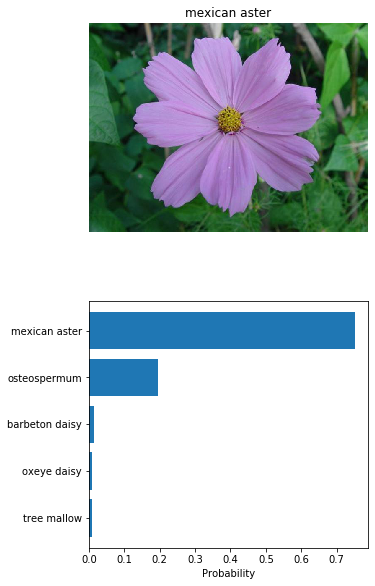

In [27]:
path = test_dir + '/34/image_06941.jpg'

SanityCheck(path)